# CUTIE - Yahiathen ABBACHE
## Abstract
In order to detect and extract total amount TTC information on receipt document, we will train a deep learnig model with a labeled database containing the receipts and their corresponding labels (which are in our case mask*). In the following section, some tasks are enumerated. 



1.   Annotate the receipts in order to build the masks (Labels), for this task we will use LabelImg (https://github.com/tzutalin/labelImg).
2. As the textual information is nedded, we will process OCR to extract the text from the images. We will use Pytesseract.(https://pypi.org/project/pytesseract/)
3.  Doing some feature engineering on the text (Cleaning, tokenization ...), Nltk and gensim ar used.
4. Pytorch transformation, PIL and CV2 are used to process the images (receipts and grids)
5. Pytorch is used to train the deep learning model.







mask*: image with 1 for the position of 'total' in the receipt, and 0 elsewhere.


## Improvements:
1. Data augmentation by preprocessing the receipts (Flip, shift texts, ...)
2. Use images with larger size (128 in the experiment for feasibility convenience)
3. Trainig a model to enhance OCR.
4. Optimize the preprocessings on the images.
5. Use Regularisation to avoid overfitting.
6. Use another loss function (dice, ...), as labels ar imbalanced, or weightning the labels.
7. Grid search Hyperparameters (Batch, lr, optimizer ... ).






### Setting the environment

In [ ]:
%%capture
!pip install pytesseract
!sudo apt install tesseract-ocr

In [ ]:
import pandas as pd
from PIL import Image
from xml.etree import ElementTree
import numpy as np
import cv2
from matplotlib.pyplot import imshow
from matplotlib import cm

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
import torch.utils.data
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, random_split
from torchvision import transforms


# import libraries
import os
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

try:
 from PIL import Image
except ImportError:
 import Image
import cv2
import pytesseract
import numpy as np
from pytesseract import Output

pytesseract.pytesseract.tesseract_cmd = (
    r'/usr/bin/tesseract'
)

from nltk.tokenize import  word_tokenize 
import nltk
nltk.download('punkt')


import gensim
from gensim import corpora

import argparse
import logging
import os
import sys


from tqdm import tqdm
import random

import time

random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
IMAGE_SIZE = 128
# path to directory with receipts and xmls directories
# data_path
#   |_receipts
#   |_xmls (Output of LabelImg software)
data_path = "/content/drive/My Drive/CUTIE_TEST"


In [ ]:
device = 'cpu'

EMBEDDING_SIZE = 32
IN_CHANNELS = 3
NB_CLASS = 2

lr=0.001
momentum=0.9
batch_size = 4
NB_EPOCH = 15

val_percent = 0.1

# Create the dataset 
dataset = ReceiptsDataset(root=data_path, transforms = apply_transformations)

# Dataloader in order to iterate over the dataset (Batch)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None,)

# Vocab size for the embedding layer
VOCAB_SIZE = len(dataset.dictionary.token2id)*255

# Split data to (Train, Eval)
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)


train_loss_list = []
eval_loss_list = []

In [ ]:
%%capture
start_time = time.time()
# Building and training the model

net = CUTIE()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)

for epoch in range(NB_EPOCH):  # loop over the dataset multiple times

    # print("epoch: ", epoch)
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        images, grids, masks = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(images.to(device), grids.to(device))
        loss = criterion(outputs.to(device), masks.squeeze(1))
        loss.backward()
        optimizer.step()

        loss_eval = eval_net(net, val_loader)

        # print(loss.item(), loss_eval)

        train_loss_list.append(loss.item())
        eval_loss_list.append(loss_eval)
    epoch+=1
    

end_time = time.time()


In [ ]:
print("Duration: ", end_time-start_time)

Text(0.5, 1.0, 'Cross entropie loss evolution during train process')

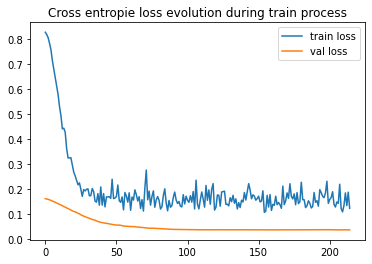

In [ ]:
plt.plot(train_loss_list, label="train loss")
plt.plot(eval_loss_list, label="val loss")
plt.legend()
plt.title("Cross entropie loss evolution during train process")



# Performing a test with a receipt

In [ ]:
receipt_sample = "/content/drive/My Drive/CUTIE_TEST/receipts/1098-receipt.jpg"
net.eval()

img = Image.open(receipt_sample).convert("RGB")
w,h = img.size
grid, dictionary = get_grid(img, dataset.dictionary)

grid = Image.fromarray(np.uint8(cm.gist_earth(grid)*255)).convert("L")


img_trans = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
  ])

  
grid_trans = transforms.Compose([                                   
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    # transforms.ToTensor()
])
img = img_trans(img)

grid = grid_trans(grid)

img = torch.as_tensor(np.array(img), dtype=torch.float32)
grid = torch.as_tensor(np.array(grid), dtype=torch.long)

img = img.unsqueeze(0)
grid = grid.unsqueeze(0)


(1, 128, 128)


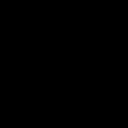

In [ ]:
with torch.no_grad():
  mask_pred = net(img, grid)
  mask_np = np.argmax(mask_pred.numpy(),1)
  print(mask_np.shape)
  mask_np = np.transpose(mask_np, (1,0,2))
  mask_np = np.transpose(mask_np, (0,2,1))

  cv2_imshow(mask_np)


## Analyze:
The model have converged to optimal (Local) solution, as the loss error seems to converge around 0.1.
In contrast, our labels are imbalanced the model have surelly learned to predict 0 in order to minimize the training loss, so we need to experiment another loss function (dice, or CE with weights, Intersection over Union for the evaluation ....), which handles imbalanced labels.[texte du lien](https://)   

# Pytorch definitions Section 

## Dataset
torch.utils.data.Dataset is an abstract class representing a dataset, our receipt dataset should inherit Dataset and override the following methods:

    __len__ so that len(dataset) returns the size of the dataset.
    __getitem__ to support the indexing such that dataset[i] can be used to get i

Let’s create a dataset class for our receipts dataset. We will load the filepaths in __init__ but leave the reading of images to __getitem__. This is memory efficient because all the images are not stored in the memory at once but read as required.

Our dataset will take an optional argument transform so that the processing on the images (resize, create the grids) can be applied on the sample.




In [ ]:
class ReceiptsDataset(torch.utils.data.Dataset):

    def __init__(self, root, transforms=None):

        self.root = root
        self.transforms = transforms

        self.imgs = sorted([path for path in os.listdir(os.path.join(root, "receipts")) if path.endswith(".jpg")])

        #load bounding coordinates
        self.xmls = sorted([path for path in os.listdir(os.path.join(root, "xmls")) if path.endswith(".xml")])

        len_min = min(len(self.imgs), len(self.xmls))
        self.imgs = self.imgs[:len_min]
        self.xmls = self.xmls[:len_min]

        self.dictionary = corpora.Dictionary([])


    def __getitem__(self, idx):

        """
        This function is the core component of dataset structure, as we read the 
        image build its corresponding mask and grid.
 
        """

        # load images ad masks
        img_path = os.path.join(os.path.join(self.root, "receipts"), self.imgs[idx])
        xml_path = os.path.join(os.path.join(self.root, "xmls"), self.xmls[idx])

        img = Image.open(img_path).convert("RGB")
        w,h = img.size

        # 0: other, 1: total: boxes
        boxes = get_boxes(xml_path)
        grid, self.dictionary = get_grid(img, self.dictionary)
        mask = get_mask(boxes, w, h)

        mask = Image.fromarray(np.uint8(cm.gist_earth(mask)*255)).convert("L")

        grid = Image.fromarray(np.uint8(cm.gist_earth(grid)*255)).convert("L")

        if self.transforms is not None:
            img, grid, mask = self.transforms(img, grid, mask)

        mask = np.where(np.array(mask)>0,1,0)


        img = torch.as_tensor(np.array(img), dtype=torch.float32)
        mask = torch.as_tensor(mask, dtype=torch.long).unsqueeze(0)
        grid = torch.as_tensor(np.array(grid), dtype=torch.long)

        return img, grid, mask
        


    def __len__(self):
        return len(self.imgs)

# CUTIE - B Model

In this section, we define the architecture of the model taking the CUTIE paper as a reference.


In [ ]:
class CUTIE(nn.Module):

  def __init__(self):
    super(CUTIE, self).__init__()
    self.OUT_CHANNELS = 32
    self.EMBEDDING_SIZE = EMBEDDING_SIZE
    self.NB_CLASS = NB_CLASS


    #grid
    self.embedding_layer = nn.Embedding(VOCAB_SIZE, EMBEDDING_SIZE)
    self.avgPool = nn.AdaptiveAvgPool2d((64,64))
    self.avgPoolFinal = nn.AdaptiveAvgPool2d((IMAGE_SIZE,IMAGE_SIZE))


    self.conv1_1 = nn.Conv2d(self.EMBEDDING_SIZE+self.OUT_CHANNELS,self.EMBEDDING_SIZE+self.OUT_CHANNELS, 1, 1 )
    self.conv1_1_layer_2 = nn.Conv2d(4*self.OUT_CHANNELS,4*self.OUT_CHANNELS, 1, 1 )
    self.conv_layer_3 = nn.Conv2d(5*self.OUT_CHANNELS,16, 3, 1, 1 )
    self.conv1_1_layer_4 = nn.Conv2d(16, self.NB_CLASS, 1, 1 )




    #image
    self.conv_layer_1 = nn.Sequential(
        nn.Conv2d(IN_CHANNELS,self.OUT_CHANNELS,3, stride=1),
        nn.BatchNorm2d(self.OUT_CHANNELS),
        nn.ReLU()
    )

    self.conv_block = nn.Sequential(
          nn.Conv2d(self.OUT_CHANNELS,self.OUT_CHANNELS,3, stride=1),
          nn.BatchNorm2d(self.OUT_CHANNELS),
          
          nn.ReLU(),
          
          nn.Conv2d(self.OUT_CHANNELS,self.OUT_CHANNELS,3, stride=1),
          nn.BatchNorm2d(self.OUT_CHANNELS),
          nn.ReLU(),
          
          nn.Conv2d(self.OUT_CHANNELS,self.OUT_CHANNELS,3, stride=2),
          nn.BatchNorm2d(self.OUT_CHANNELS),
          nn.ReLU()
        )
    
    self.atrous_block = nn.Sequential(
        nn.Conv2d(self.OUT_CHANNELS+self.EMBEDDING_SIZE, self.OUT_CHANNELS, 3, stride = 1, padding = 0, dilation=2),
        nn.ReLU(),
        
        nn.Conv2d(self.OUT_CHANNELS, self.OUT_CHANNELS, 3, stride = 1, padding = 0, dilation=2),
        nn.ReLU(),
        
        nn.Conv2d(self.OUT_CHANNELS, self.OUT_CHANNELS, 3, stride = 1, padding = 0, dilation=2),
        nn.ReLU(),

        nn.Conv2d(self.OUT_CHANNELS, self.OUT_CHANNELS, 3, stride = 1, padding = 0, dilation=2),
        nn.BatchNorm2d(self.OUT_CHANNELS),
        nn.ReLU()
  
    )


    #aspp
    self.aspp_layer_1 = nn.Conv2d(self.OUT_CHANNELS, self.OUT_CHANNELS, 7, stride=1, dilation=4)
    self.aspp_layer_2 = nn.Conv2d(self.OUT_CHANNELS, self.OUT_CHANNELS, 5, padding=1, dilation=8)
    self.aspp_layer_3 = nn.Conv2d(self.OUT_CHANNELS, self.OUT_CHANNELS, 3, padding=1, dilation=16)




  def forward(self, images, grids):

    # grid
    embed = self.embedding_layer(grids)
    embed_transpose = torch.transpose(embed, 2, 3)
    embed_transpose = torch.transpose(embed_transpose, 1, 2)


    #image
    out_conv_layer_1 = self.conv_layer_1(images)

    out_conv_block = self.conv_block(out_conv_layer_1)


    embed_and_conv = torch.cat((self.avgPool(embed_transpose), self.avgPool(out_conv_block)), 1)

    embed_and_conv = self.conv1_1(embed_and_conv)

    out_atrous_block = self.atrous_block(embed_and_conv)

    out_aspp_0 = self.avgPool(out_atrous_block)
    out_aspp_1 = self.avgPool(self.aspp_layer_1(out_atrous_block))
    out_aspp_2 = self.avgPool(self.aspp_layer_2(out_atrous_block))
    out_aspp_3 = self.avgPool(self.aspp_layer_3(out_atrous_block))

    aspp = torch.cat([out_aspp_0, out_aspp_1, out_aspp_2, out_aspp_3], dim=1)

    aspp = self.avgPoolFinal(aspp)
    aspp = self.conv1_1_layer_2(aspp)
    first_layer = self.avgPoolFinal(out_conv_layer_1)
    
    aspp_and_first_layer = torch.cat([first_layer, aspp], dim=1)

    aspp_and_first_layer = self.conv_layer_3(aspp_and_first_layer)
    y_hat = self.conv1_1_layer_4(aspp_and_first_layer)

    return y_hat




def eval_net(net, evalloader):
  """
  Function to evaluate the model on unseen data 
  net: Network CUTIE
  evalloader: Dataloader containig data for validation
  """
  
  net.eval()
  loss_eval = 0

  for i, data in enumerate(evalloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    images, grids, masks = data


    with torch.no_grad():
      # forward 
      outputs = net(images.to(device), grids.to(device))
      loss = criterion(outputs.to(device), masks.squeeze(1))

      loss_eval+=loss.item()
    net.train()
    return loss_eval/len(evalloader)
  
def apply_transformations(im, grid, mask):

  img_trans = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
  ])

  mask_trans = transforms.Compose([                                   
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    # transforms.ToTensor()
            
  ])
  
  grid_trans = transforms.Compose([                                   
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    # transforms.ToTensor()
            
  ])

  return img_trans(im), grid_trans(grid), mask_trans(mask)

def get_boxes(xml_path):
    tree = ElementTree.parse(xml_path)
    parsed = tree.getroot()

    boxes = []

    for obj in parsed.findall("object"):

        xmin = int(obj.find("bndbox/xmin").text)
        ymin = int(obj.find("bndbox/ymin").text)
        xmax = int(obj.find("bndbox/xmax").text)
        ymax = int(obj.find("bndbox/ymax").text)

        boxes.append([xmin, ymin, xmax, ymax])
    return boxes


def get_mask(boxes, w, h):
    
    mask = np.zeros((h, w))
    positive_label = 1

    for xmin, ymin, xmax, ymax in boxes:
        mask[ymin: ymax, xmin: xmax] = positive_label

    return mask

# Utils

# GRID
Among the most important concepts of the approach described in the paper is the use of a grid.
In order to take in account the spatial information of the receipt we provide the model with a grid containig tokens (word representation), in the same order as the image.

1.   Preprocess the image for OCR
2.   We extract the text with OCR (Pytesseract)
3. Segment the text (Word segmentation is the problem of dividing a string into its component words)
4.  Split verticaly the grid into the number of sentences.
4. Split lines horizontally into the number of tokens of each line.
5. set each box pixel with its corresponding token.
6. Mapping the tokens to their equivalent integer using gensim 





In [ ]:

def get_grid(image, gensim_dictionary):
  
  # The number of pixels between two tokens (Horizontally)
  STRIDE = 4

  image = np.array(image)
  img_h, img_w, _ = image.shape

  grid = np.zeros((img_h, img_w))

  custom_config = r'-l eng+it --psm 6'

  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

  text = pytesseract.image_to_string(thresh, config=custom_config)


  line_text_list = text.split("\n")
  line_text_list_tokenized = [word_tokenize(line) for line in line_text_list]

  gensim_dictionary.add_documents(line_text_list_tokenized)


  nb_sentences = len(line_text_list_tokenized)
  nb_token_per_line = [len(line) for line in line_text_list_tokenized]

 
  bboxes_h = int((img_h - 2*nb_sentences) / nb_sentences)
  bboxes_per_line_w = ((img_w - 2*np.array(nb_token_per_line))/np.array(nb_token_per_line)).astype(int)
  # Building the grid
  line_cursor = 0
  for line_i in range(nb_sentences):
    col_idx = 0

    for token_i in line_text_list_tokenized[line_i]:
    
      grid[line_cursor:line_cursor+bboxes_h, col_idx:col_idx+bboxes_per_line_w[line_i]] = token2id(gensim_dictionary, token_i)
      col_idx+=(bboxes_per_line_w[line_i]+STRIDE)
    
    line_cursor+=(bboxes_h+STRIDE)
  
  return grid, gensim_dictionary


In [ ]:
def token2id(gensim_dictionary, token):
  """
  Models input are numerical, thus we need to map words to integers
  function which maps tokens to integers using gensim dictionary
  """
  return gensim_dictionary.token2id[token]
